## Merge Data

In [17]:
import pandas as pd
import sqlite3

# Define file paths
public_theme_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/public_theme.xlsx"
expert_theme_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/expert_theme.xlsx"
db_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/arctic_shift/filtered_data/relevant_data.db"

# Load topic-theme associations from the correct sheets
public_topics_df = pd.read_excel(public_theme_path, sheet_name='public_topic_theme_count', header=0)
expert_topics_df = pd.read_excel(expert_theme_path, sheet_name='expert_topic_theme_count', header=0)

# Rename the first column to 'Topic' for consistency
public_topics_df.rename(columns={public_topics_df.columns[0]: 'Topic'}, inplace=True)
expert_topics_df.rename(columns={expert_topics_df.columns[0]: 'Topic'}, inplace=True)

# Connect to the database and load document-topic associations
conn = sqlite3.connect(db_path)
public_doc_topic_df = pd.read_sql_query("SELECT * FROM updated_public_doc_topic", conn)
expert_doc_topic_df = pd.read_sql_query("SELECT * FROM expert_doc_topic", conn)

# Rename columns for merging if necessary
if 'topic' in public_doc_topic_df.columns:
    public_doc_topic_df.rename(columns={'topic': 'Topic'}, inplace=True)
if 'topic' in expert_doc_topic_df.columns:
    expert_doc_topic_df.rename(columns={'topic': 'Topic'}, inplace=True)

# Merge document-topic associations with topic-theme associations
public_merged_df = pd.merge(public_doc_topic_df, public_topics_df, left_on='Topic', right_on='Topic')
expert_merged_df = pd.merge(expert_doc_topic_df, expert_topics_df, left_on='Topic', right_on='Topic')

# Display column names to determine correct number of columns
print("Public Merged Data Columns:", public_merged_df.columns)
print("Expert Merged Data Columns:", expert_merged_df.columns)

# Store the merged dataframes back to the database
public_merged_df.to_sql('public_merged_data', conn, if_exists='replace', index=False)
expert_merged_df.to_sql('expert_merged_data', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

# Display the first few rows of the merged dataframes
print("Public Merged Data:")
print(public_merged_df.head())

print("\nExpert Merged Data:")
print(expert_merged_df.head())


Public Merged Data Columns: Index(['id', 'document', 'Topic', 'Count', 'Theme', 'New Label',
       'Detailed_Summary', 'Old Name', 'Representation'],
      dtype='object')
Expert Merged Data Columns: Index(['id', 'document', 'Topic', 'Count', 'Theme', 'New Label',
       'Detailed_Summary', 'Old Name', 'Representation'],
      dtype='object')
Public Merged Data:
        id                                           document  Topic  Count  \
0  kxh8adk  yeah people either didn't get to experience wh...      2    591   
1  kxhy6n7  i discovered that i can make it act like a per...      0   2275   
2  kxie58r  of course its a funny bit, i am a fan of bill ...     -1    971   
3  kxiezxm  no, you don't sound insane at all, you know ev...     -1    971   
4  kxin8br  i tried it:\n\n"a character made a joke that o...      0   2275   

                                            Theme  \
0                      The Impact of AI on Coding   
1  Practical Applications of ChatGPT in Education   


## Prepare and Clean data

In [18]:
# Before removal
num_public_docs_before = len(public_merged_df)
num_expert_docs_before = len(expert_merged_df)
num_public_topics_before = public_merged_df['Topic'].nunique()
num_expert_topics_before = expert_merged_df['Topic'].nunique()
num_public_themes_before = public_merged_df['Theme'].nunique()
num_expert_themes_before = expert_merged_df['Theme'].nunique()

# Remove irrelevant themes and topics, including topic -1
public_merged_df = public_merged_df[(public_merged_df['Theme'] != 'Irrelavant') & (public_merged_df['Topic'] != -1)]
expert_merged_df = expert_merged_df[(expert_merged_df['Theme'] != 'Irrelavant') & (expert_merged_df['Topic'] != -1)]

# After removal
num_public_docs_after = len(public_merged_df)
num_expert_docs_after = len(expert_merged_df)
num_public_topics_after = public_merged_df['Topic'].nunique()
num_expert_topics_after = expert_merged_df['Topic'].nunique()
num_public_themes_after = public_merged_df['Theme'].nunique()
num_expert_themes_after = expert_merged_df['Theme'].nunique()

print("Public Data Before Removal: Documents - {}, Topics - {}, Themes - {}".format(num_public_docs_before, num_public_topics_before, num_public_themes_before))
print("Public Data After Removal: Documents - {}, Topics - {}, Themes - {}".format(num_public_docs_after, num_public_topics_after, num_public_themes_after))

print("Expert Data Before Removal: Documents - {}, Topics - {}, Themes - {}".format(num_expert_docs_before, num_expert_topics_before, num_expert_themes_before))
print("Expert Data After Removal: Documents - {}, Topics - {}, Themes - {}".format(num_expert_docs_after, num_expert_topics_after, num_expert_themes_after))

# Check if 'Irrelevant' theme is still present
print("Public Data Themes:", public_merged_df['Theme'].unique())
print("Expert Data Themes:", expert_merged_df['Theme'].unique())

Public Data Before Removal: Documents - 8309, Topics - 44, Themes - 12
Public Data After Removal: Documents - 7054, Topics - 37, Themes - 11
Expert Data Before Removal: Documents - 1133, Topics - 47, Themes - 10
Expert Data After Removal: Documents - 940, Topics - 43, Themes - 9
Public Data Themes: ['The Impact of AI on Coding'
 'Practical Applications of ChatGPT in Education'
 'Academic Integrity and AI Detection' 'The Impact of AI on Learning'
 'Effective Use of AI in Education'
 'Other Ethical Concerns of AI in Education'
 'Integration of AI in Pedagogy' 'The Impact of AI on Email Communication'
 'Integration of AI in Academic Research'
 'The Impact of AI in Language Learning' 'The Impact of AI on Writing']
Expert Data Themes: ['Ethical Concerns in AI for Academic Research'
 'Transforming Education and Institutional Practices with AI'
 'Integration of AI in Pedagogy' 'Academic Integrity and AI Detection'
 'Enhancing Accessibility and Inclusivity with AI in Education'
 'Workforce cha

## Sentiment Analysis on Public Data with VADER

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to public data
public_merged_df['Sentiment'] = public_merged_df['document'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


## Sentiment Analysis on Expert Data using BERTbased Model
### using distilbert-base-uncased from the Hugging Face transformers library

In [7]:
from transformers import pipeline
import torch
from tqdm import tqdm

# Initialize DistilBERT sentiment analyzer
device = 0 if torch.cuda.is_available() else -1
distilbert_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased", device=device)

# Function to get sentiment score using DistilBERT
def get_distilbert_sentiment(text):
    max_length = 512
    if len(text) > max_length:
        text = text[:max_length]
    result = distilbert_analyzer(text)
    return result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
# Function to run batch sentiment analysis
def batch_sentiment_analysis(documents, batch_size=32):
    num_batches = (len(documents) + batch_size - 1) // batch_size
    print(f"Total number of batches to process: {num_batches}")
    
    sentiment_scores = []
    
    for i in tqdm(range(num_batches)):
        batch = documents[i*batch_size:(i+1)*batch_size]
        batch_scores = [get_distilbert_sentiment(doc) for doc in batch]
        sentiment_scores.extend(batch_scores)
    
    return sentiment_scores

# usage with expert data
expert_sentiments = batch_sentiment_analysis(expert_merged_df['document'].tolist())

# Add the sentiment scores to the dataframes
expert_merged_df['Sentiment'] = expert_sentiments


Total number of batches to process: 36


100%|██████████| 36/36 [04:04<00:00,  6.80s/it]


In [11]:
# Test the sentiment analysis on known positive, neutral, and negative sentences to validate the results.
test_sentences = [
    "I love this product, it is amazing!",
    "This is a neutral sentence.",
    "I hate this product, it is terrible!"
]

for sentence in test_sentences:
    print(f"Sentence: {sentence}")
    print(f"VADER Sentiment: {analyzer.polarity_scores(sentence)['compound']}")
    print(f"DistilBERT Sentiment: {get_distilbert_sentiment(sentence)}")
    print()


Sentence: I love this product, it is amazing!
VADER Sentiment: 0.8516
DistilBERT Sentiment: -0.5088611841201782

Sentence: This is a neutral sentence.
VADER Sentiment: 0.0772
DistilBERT Sentiment: -0.5040484666824341

Sentence: I hate this product, it is terrible!
VADER Sentiment: -0.7959
DistilBERT Sentiment: -0.5035358667373657



## Using the nlptown/bert-base-multilingual-uncased-sentiment model for both datasets

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
import re

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    return text

# Function to get BERT sentiment
def get_bert_sentiment(text):
    text = preprocess_text(text)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    scores = outputs.logits[0].detach().numpy()
    scores = torch.nn.functional.softmax(torch.tensor(scores), dim=0)
    labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
    sentiment = {label: float(score) for label, score in zip(labels, scores)}
    return sentiment


In [18]:
# Function to run batch sentiment analysis using the BERT model
def batch_sentiment_analysis(documents, batch_size=32):
    num_batches = (len(documents) + batch_size - 1) // batch_size
    print(f"Total number of batches to process: {num_batches}")
    
    sentiment_scores = []
    
    for i in tqdm(range(num_batches)):
        batch = documents[i*batch_size:(i+1)*batch_size]
        batch_scores = [get_bert_sentiment(doc) for doc in batch]
        sentiment_scores.extend(batch_scores)
    
    return sentiment_scores

In [ ]:
expert_sentiments = batch_sentiment_analysis(expert_merged_df['document'].tolist())
print("Expert Sentiments Calculated:", expert_sentiments[:5])  # Check the first few results

In [ ]:
# Add the sentiment scores to the DataFrame
expert_merged_df['Sentiment'] = expert_sentiments
print("Expert DataFrame with Sentiments:")
print(expert_merged_df.head())  # Verify the first few rows

In [26]:
# Usage with public data
public_sentiments = batch_sentiment_analysis(public_merged_df['document'].tolist())

Total number of batches to process: 260


100%|██████████| 260/260 [1:03:56<00:00, 14.76s/it]


In [63]:
# Add the sentiment scores to the dataframes
public_merged_df['Sentiment'] = public_sentiments

In [ ]:
print("Public DataFrame with Sentiments:")
print(public_merged_df.head())  # Verify the first few rows

In [ ]:
import sqlite3

# Convert the sentiment dictionary into individual columns
def sentiment_dict_to_columns(sentiment_dict):
    return pd.Series(sentiment_dict)

# Check if 'Sentiment' column exists and has correct data
if 'Sentiment' in expert_merged_df.columns:
    # Convert the sentiment dictionary into individual columns
    expert_sentiment_df = expert_merged_df['Sentiment'].apply(sentiment_dict_to_columns)
    expert_merged_df = pd.concat([expert_merged_df, expert_sentiment_df], axis=1)
    expert_merged_df.drop(columns=['Sentiment'], inplace=True)
    print("Expert DataFrame after expanding Sentiment column:")
    print(expert_merged_df.head())  # Verify the expanded DataFrame
else:
    print("Error: 'Sentiment' column not found in expert_merged_df.")


if 'Sentiment' in public_merged_df.columns:
    # Convert the sentiment dictionary into individual columns
    public_sentiment_df = public_merged_df['Sentiment'].apply(sentiment_dict_to_columns)
    public_merged_df = pd.concat([public_merged_df, public_sentiment_df], axis=1)
    public_merged_df.drop(columns=['Sentiment'], inplace=True)
    print("Public DataFrame after expanding Sentiment column:")
    print(public_merged_df.head())  # Verify the expanded DataFrame
else:
    print("Error: 'Sentiment' column not found in public_merged_df.")

In [ ]:
# Connect to the SQLite database
db_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/arctic_shift/filtered_data/relevant_data.db"
conn = sqlite3.connect(db_path)


public_merged_df.to_sql('public_merged_data', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

# Display the first few rows of the expanded dataframes
print("Public Expanded Data:")
print(public_merged_df.head())


In [ ]:
# Connect to the SQLite database
db_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/arctic_shift/filtered_data/relevant_data.db"
conn = sqlite3.connect(db_path)

expert_merged_df.to_sql('expert_merged_data', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

print("\nExpert Expanded Data:")
print(expert_merged_df.head())

## Determine the Final Sentiment for Each Document

In [80]:
import sqlite3
import pandas as pd

# Path to the SQLite database
db_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/arctic_shift/filtered_data/relevant_data.db"

# Connect to the database and load the data
with sqlite3.connect(db_path) as conn:
    expert_df = pd.read_sql_query("SELECT * FROM expert_merged_data", conn)
    public_df = pd.read_sql_query("SELECT * FROM public_merged_data", conn)

# Exclude documents with the theme "Irrelavant"
expert_df = expert_df[expert_df['Theme'] != 'Irrelavant']
public_df = public_df[public_df['Theme'] != 'Irrelavant']

# Ensure all sentiment columns are numeric
sentiment_columns = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
expert_df[sentiment_columns] = expert_df[sentiment_columns].apply(pd.to_numeric, errors='coerce')
public_df[sentiment_columns] = public_df[sentiment_columns].apply(pd.to_numeric, errors='coerce')

# Function to determine the final sentiment for each document
def determine_final_sentiment(row):
    sentiment_scores = row[sentiment_columns]
    return sentiment_scores.idxmax()

# Apply the function to determine final sentiment for each document
expert_df['Final Sentiment'] = expert_df.apply(determine_final_sentiment, axis=1)
public_df['Final Sentiment'] = public_df.apply(determine_final_sentiment, axis=1)

# Display the first few rows to verify
print("Expert DataFrame with Final Sentiment:")
print(expert_df[['document', 'Final Sentiment']].head())

print("\nPublic DataFrame with Final Sentiment:")
print(public_df[['document', 'Final Sentiment']].head())


Expert DataFrame with Final Sentiment:
                                            document Final Sentiment
0  a journal reviewer accused lizzie wolkovich of...        negative
1  importantly to me — about how ai could corrupt...   very negative
2  we need to be able to call out fraud and misco...        negative
3  exactly a year ago, we shared the advice of 11...        positive
4   answers below have been edited for length and...        positive

Public DataFrame with Final Sentiment:
                                            document Final Sentiment
0  yeah people either didn't get to experience wh...        negative
1  i discovered that i can make it act like a per...         neutral
2  of course its a funny bit, i am a fan of bill ...         neutral
3  no, you don't sound insane at all, you know ev...   very negative
4  i tried it:\n\n"a character made a joke that o...         neutral


## Calculate Overall Sentiment Distribution and Sentiment Distribution by Theme

In [82]:
# Overall sentiment distribution DataFrame for expert data
expert_overall_sentiment_df = expert_df['Final Sentiment'].value_counts(normalize=True).reset_index()
expert_overall_sentiment_df.columns = ['Sentiment', 'Proportion']

# Overall sentiment distribution DataFrame for public data
public_overall_sentiment_df = public_df['Final Sentiment'].value_counts(normalize=True).reset_index()
public_overall_sentiment_df.columns = ['Sentiment', 'Proportion']

# Sentiment distribution by theme DataFrame for expert data
expert_sentiment_by_theme_df = expert_df.groupby('Theme')['Final Sentiment'].value_counts(normalize=True).unstack().reset_index()
expert_sentiment_by_theme_df['Most Common Sentiment'] = expert_sentiment_by_theme_df[sentiment_columns].idxmax(axis=1)

# Sentiment distribution by theme DataFrame for public data
public_sentiment_by_theme_df = public_df.groupby('Theme')['Final Sentiment'].value_counts(normalize=True).unstack().reset_index()
public_sentiment_by_theme_df['Most Common Sentiment'] = public_sentiment_by_theme_df[sentiment_columns].idxmax(axis=1)


In [86]:
# Save the DataFrames to Excel files
output_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/sentiment_analysis_results.xlsx"
with pd.ExcelWriter(output_path) as writer:
    expert_overall_sentiment_df.to_excel(writer, sheet_name='Expert Overall Sentiment', index=False)
    public_overall_sentiment_df.to_excel(writer, sheet_name='Public Overall Sentiment', index=False)
    expert_sentiment_by_theme_df.to_excel(writer, sheet_name='Expert Sentiment by Theme', index=False)
    public_sentiment_by_theme_df.to_excel(writer, sheet_name='Public Sentiment by Theme', index=False)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from each sheet
file_path = '/Users/vesper/Desktop/LSE/Capstone Project/dissertation/sentiment_analysis_results.xlsx'
expert_overall_sentiment_df = pd.read_excel(file_path, sheet_name='Expert Overall Sentiment')
public_overall_sentiment_df = pd.read_excel(file_path, sheet_name='Public Overall Sentiment')
expert_sentiment_by_theme_df = pd.read_excel(file_path, sheet_name='Expert Sentiment by Theme')
public_sentiment_by_theme_df = pd.read_excel(file_path, sheet_name='Public Sentiment by Theme')


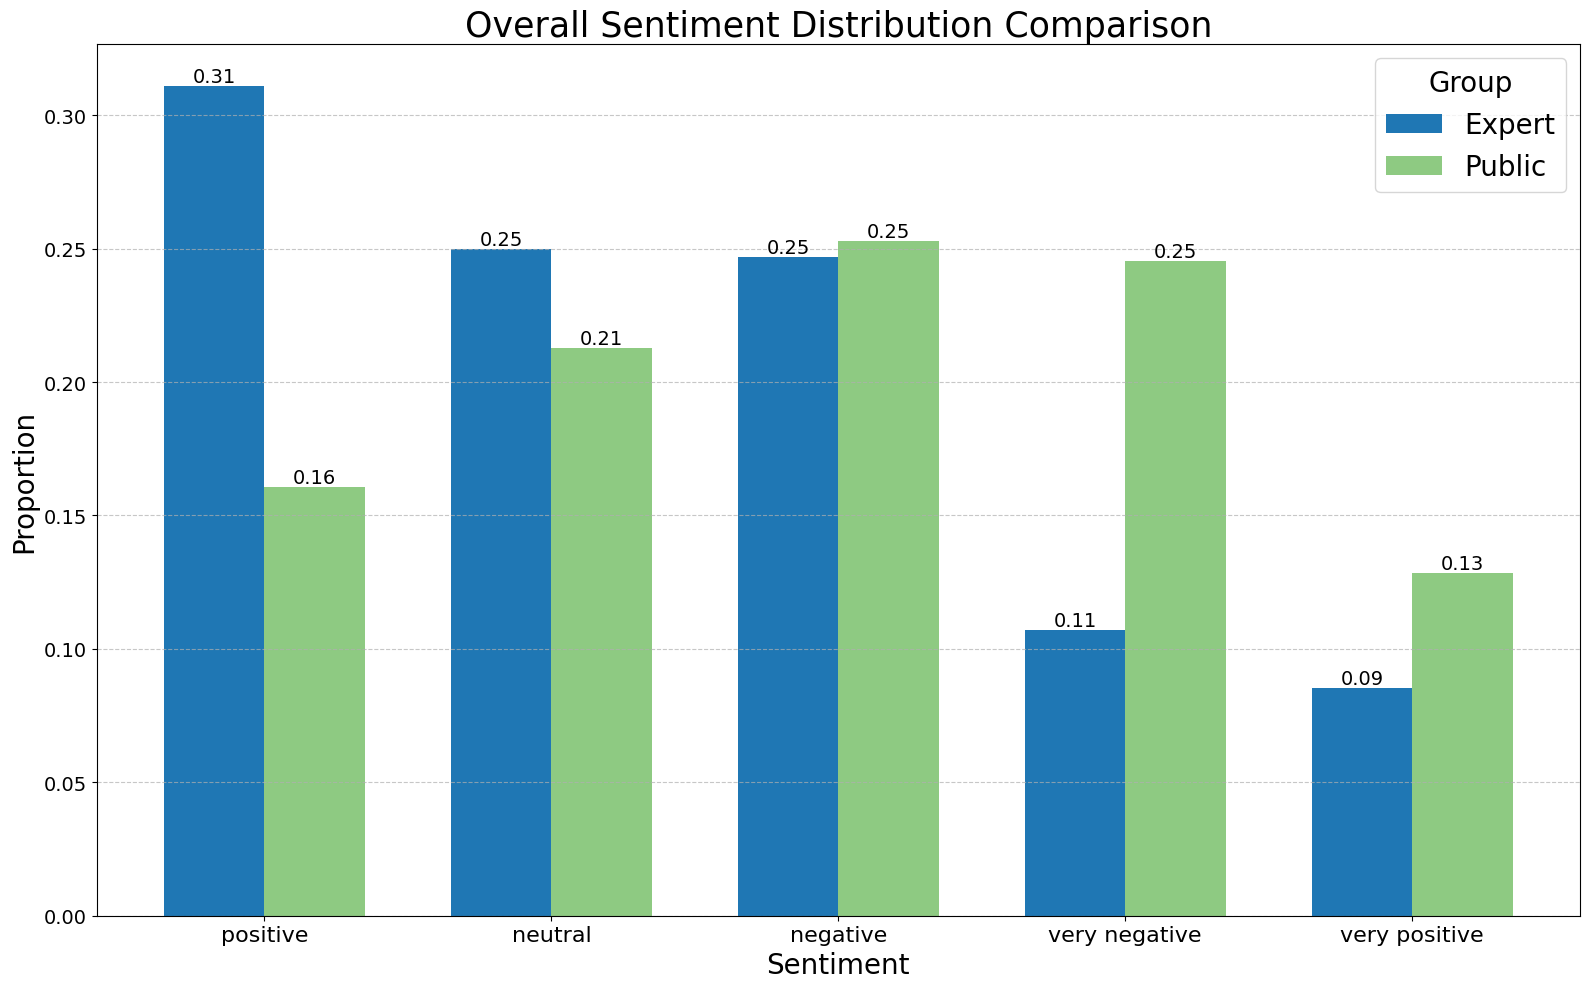

In [26]:
# Merge data for side-by-side comparison of overall sentiment
overall_sentiment_df = pd.merge(expert_overall_sentiment_df, public_overall_sentiment_df, on='Sentiment', suffixes=('_Expert', '_Public'))

# Plot side-by-side bar chart with improved colors and larger titles
plt.figure(figsize=(16, 10))
bar_width = 0.35
index = range(len(overall_sentiment_df['Sentiment']))

# Define a new color palette
expert_color = '#1f77b4'
public_color = '#8ECA82'

bars1 = plt.bar(index, overall_sentiment_df['Proportion_Expert'], bar_width, label='Expert', color=expert_color)
bars2 = plt.bar([i + bar_width for i in index], overall_sentiment_df['Proportion_Public'], bar_width, label='Public', color=public_color)

plt.xlabel('Sentiment', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.title('Overall Sentiment Distribution Comparison', fontsize=25)
plt.xticks([i + bar_width / 2 for i in index], overall_sentiment_df['Sentiment'], fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=20, title='Group', title_fontsize='20')

# Add data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=14)

add_labels(bars1)
add_labels(bars2)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('/Users/vesper/Desktop/LSE/Capstone Project/dissertation/overall_sentiment_comparison.png')
plt.show()